In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from sklearn import neural_network as nn
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Permuted Data")
df

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


,Standardized_SMILES,pchembl_value,MolWt,LogP,QED,Fingerprints
0,O=C(c1noc(-c2ccccc2)n1)N1CCC(Oc2ccc(CN3CCCC3)c...,5.12,432.524,4.01600,0.586002,[0 0 1 ... 0 0 0]
1,CN(CCN1CCN(C2COOC2)C1=O)CC12CCC(CC1)C2(C)C,5.20,351.491,2.20260,0.688448,[0 0 0 ... 0 0 0]
2,CCC(NC(=O)c1ccc(Cl)cc1)C1C2CC(n3c(C)nc4ccc(F)c...,5.69,425.935,5.54292,0.582694,[0 0 0 ... 0 0 0]
3,COc1cc(N2CCN(CCO)CC2)ccc1N=c1nc(-c2cnc3ccccn23...,5.43,479.972,2.73310,0.441384,[0 0 0 ... 0 0 0]
4,CNC(C)c1cc(F)ccc1Oc1ccc(Cl)c(Cl)c1,5.17,314.187,5.20520,0.836697,[0 0 0 ... 0 0 0]
...,...,...,...,...,...,...
1257,CC1(N)CCC(N=c2c(C(N)=O)c[nH]n3cc(-c4cccc(F)c4)...,5.12,395.482,2.97910,0.634812,[0 0 0 ... 0 0 0]
1258,CCc1cc(Oc2cc(Cl)ccc2CNC)ccc1Cl,5.94,310.224,5.06750,0.832455,[0 0 0 ... 0 0 0]
1259,COc1cc(-c2cn(C3CC([Si](C)(C)C)CCNC3=O)nn2)ccc1...,5.20,438.608,3.60732,0.615122,[0 0 0 ... 0 0 0]
1260,CCC(NC(=O)c1ccc(Cl)cc1)C1C2CC(n3cnc4cc(F)cc(F)...,6.24,429.898,5.37360,0.591999,[0 0 0 ... 0 0 0]


In [48]:
# Generate Morgan Fingerprints
def generate_fingerprints(smiles, radius=2, nBits=20488):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    else:
        return np.zeros((nBits,))

df['Fingerprints'] = df['Standardized_SMILES'].apply(generate_fingerprints)

# Prepare features and target
X = np.array(list(df['Fingerprints']))
y = df['pchembl_value'].values

In [49]:
smiles = df['Standardized_SMILES'].values

In [50]:
MolWt = df['MolWt'].values
LogP = df['LogP'].values
QED=df['QED'].values

In [51]:
df

,Standardized_SMILES,pchembl_value,MolWt,LogP,QED,Fingerprints
0,CNC(C)c1cc(F)ccc1Oc1ccc(Cl)c(Cl)c1,5.17,314.187,5.20520,0.836697,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CC(C)=CCn1c(N2CCCNCC2)c(C#N)c2c1c(=O)n(Cc1c(C#...,6.05,522.613,2.60746,0.399586,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,O=C(CN=c1[nH]c(C(F)(F)F)nc2ccc(C(F)(F)F)cc12)N...,4.49,574.551,3.58850,0.404278,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CC(c1cccc(C(F)(F)F)c1)N1CCN(CCN2Cc3ccccc3C2)C1=O,5.90,403.448,4.51980,0.734015,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CC(C)=CCn1c(N2CCCNCC2)c(C#N)c2c1c(=O)n(Cc1ncc3...,5.75,522.613,2.60746,0.399586,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
1257,COc1ccc(C23CC2CN(CCCSc2nnc(-c4ocnc4C)n2C)C3)cc...,5.90,493.555,4.56162,0.336575,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1258,CC1CN(CCc2ccc([N+](=O)[O-])cc2)CCN1CCc1ccc([N+...,9.12,398.463,3.29430,0.500349,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1259,CN(C(=O)Cc1ccc(-n2cnnn2)cc1)C1CCN(Cc2ccc(C(F)(...,5.57,476.478,3.29460,0.511142,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1260,CC(C)OCC(Oc1ncnc2c1cnn2-c1ncccc1Cl)C(=O)N=c1cc...,4.20,488.335,3.14530,0.424432,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [52]:
#Now incorporate this sort of noise into df during the training

In [53]:
X.shape

(1262, 20488)

In [54]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from math import sqrt

def perform_fcv(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]

    rmse=list()
    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        model = RandomForestRegressor(n_estimators=min(25,round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
                                      
        X_test = X[start:stop]
        y_test = y[start:stop]
        smiles_test = smiles[start:stop]
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        #print(discoveries.shape)
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        #print(discoveries.shape)
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    # Optionally, save the results to a DataFrame
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        'Sort By': sort_by_all
    })

    # Saving to CSV (optional)
    results_df.to_csv("unsorted_fcv_results.csv", index=False)

    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

PearsonRResult(statistic=0.552986446155127, pvalue=1.889782355804038e-11)
PearsonRResult(statistic=0.7521680718963693, pvalue=3.2724930327008017e-24)
PearsonRResult(statistic=0.8299154363914594, pvalue=3.204223514251657e-33)
PearsonRResult(statistic=0.8410735916135146, pvalue=6.865509385965583e-35)
PearsonRResult(statistic=0.8692677771692716, pvalue=9.406986418688196e-40)
PearsonRResult(statistic=0.8178860252938194, pvalue=1.4941233229020886e-31)
PearsonRResult(statistic=0.7603601127737732, pvalue=5.380379577442112e-25)
PearsonRResult(statistic=0.7956377723116812, pvalue=9.079514750167099e-29)
PearsonRResult(statistic=0.8620228622186635, pvalue=5.384108124692521e-39)


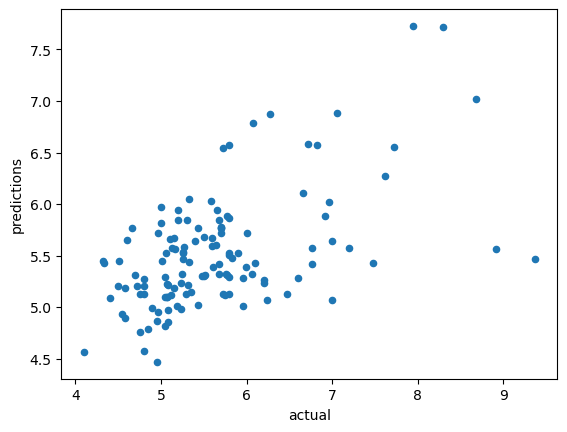

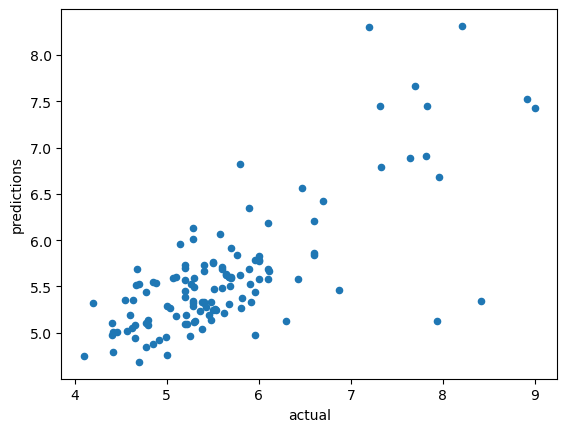

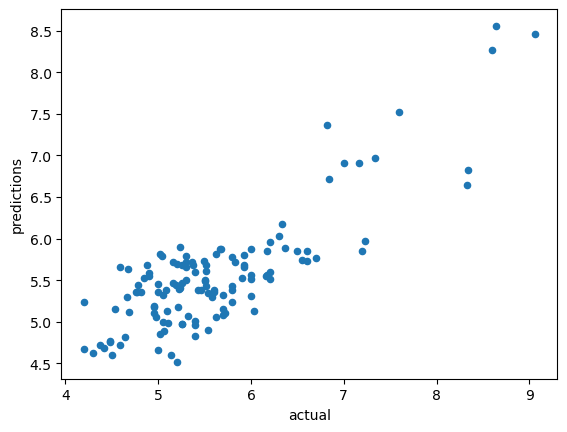

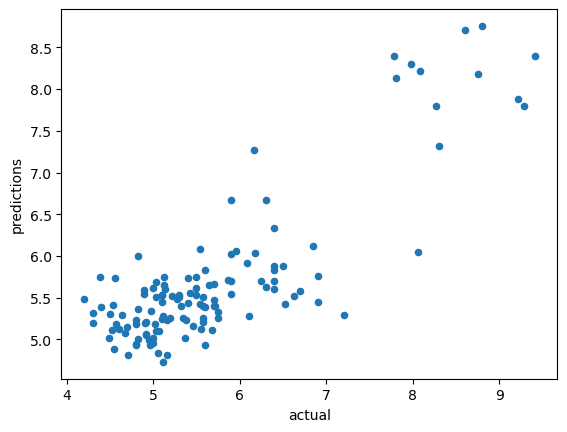

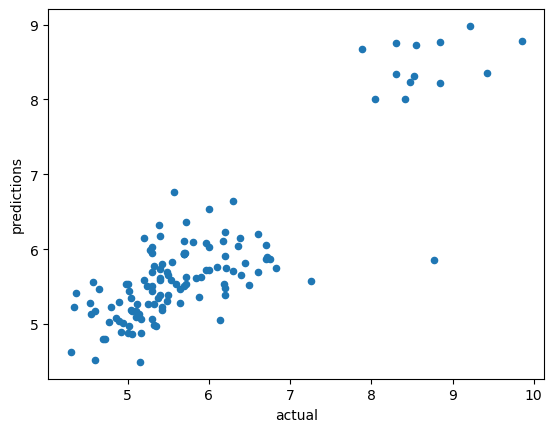

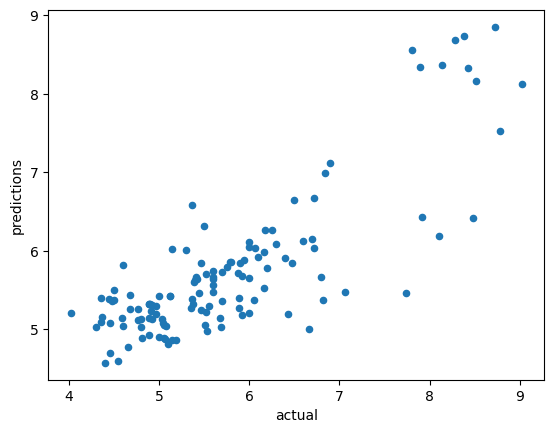

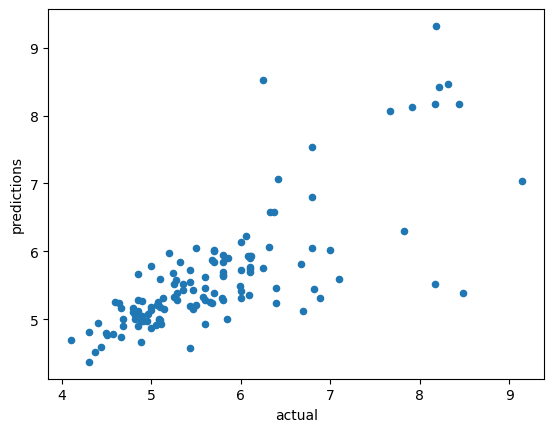

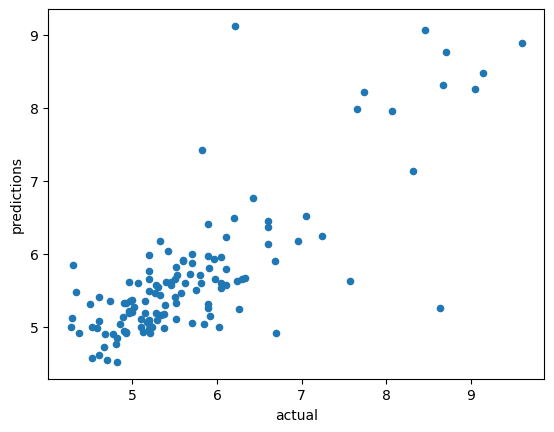

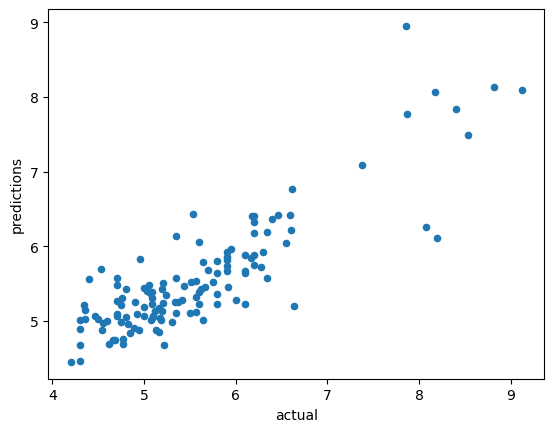

In [55]:
# Example Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df, false_disc, true_disc, true_ignore, false_ignore,rmse = perform_fcv(X, y, smiles, sort_by=None, additional_info=df["QED"])

In [56]:
for i in np.arange(len(true_disc)):
    print(true_disc[i].shape)

(23, 3)
(21, 3)
(22, 3)
(26, 3)
(22, 3)
(28, 3)
(35, 3)
(27, 3)
(37, 3)


In [57]:
for i in np.arange(len(true_disc)):
    print(false_disc[i].shape)

(11, 3)
(11, 3)
(13, 3)
(5, 3)
(5, 3)
(7, 3)
(6, 3)
(13, 3)
(6, 3)


In [58]:
for i in np.arange(len(true_disc)):
    print(false_ignore[i].shape)

(22, 3)
(14, 3)
(21, 3)
(27, 3)
(12, 3)
(20, 3)
(10, 3)
(17, 3)
(18, 3)


In [59]:
for i in np.arange(len(true_disc)):
    print(true_ignore[i].shape)

(68, 3)
(74, 3)
(68, 3)
(67, 3)
(85, 3)
(71, 3)
(74, 3)
(65, 3)
(65, 3)


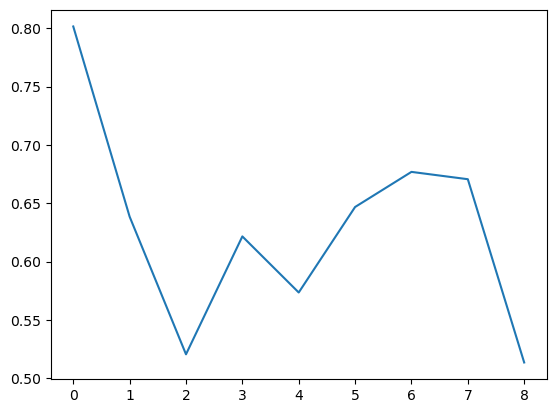

[0.8014542250102804, 0.6385530063129292, 0.5206536830386377, 0.6216345593411853, 0.5735986866558649, 0.6468304286998747, 0.6769073132960307, 0.6706335743989493, 0.5136581222588618]


In [60]:
plt.plot(rmse)
plt.show()
print(rmse)

In [61]:
def plot_graphs(data, results_df):
    
    results_df =pd.merge(data, results_df, 
                         left_on="Standardized_SMILES", right_on="Standardized_SMILES")
    
    # Calculate absolute errors and adjust results
    results_df['Error'] = (results_df['True Values'] - results_df['Predictions']).abs().round(2)
    results_df['True Values'] = results_df['True Values'].round(2)
    results_df['Predictions'] = results_df['Predictions'].round(2)

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['MolWt'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By MolWt')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
        # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['QED'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By QED')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['LogP'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By LogP')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['pchembl_value'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By IC50 Sorted')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()

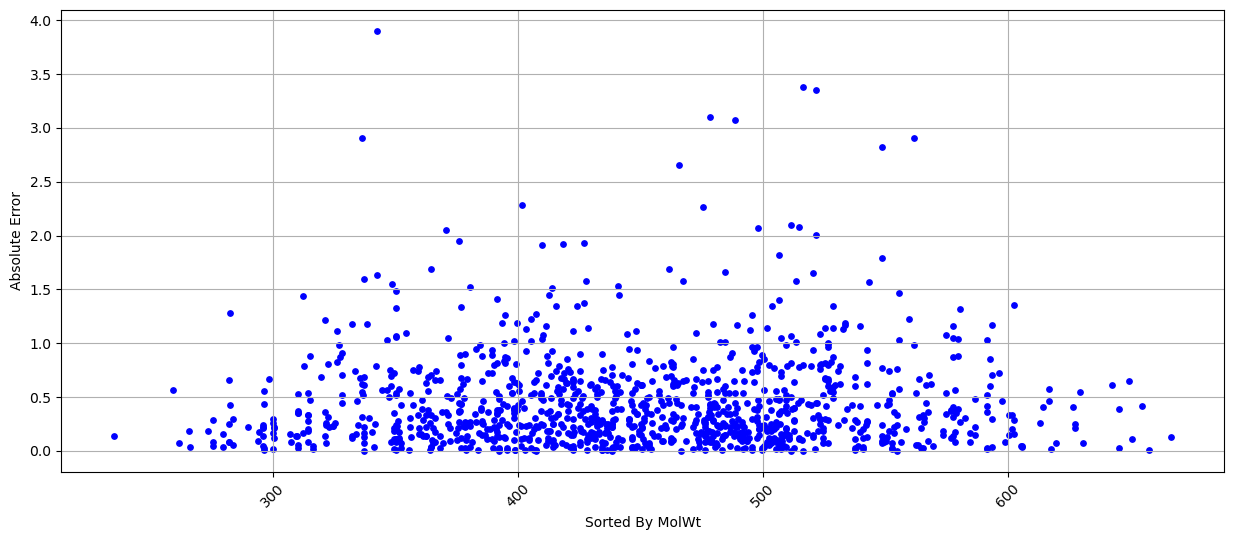

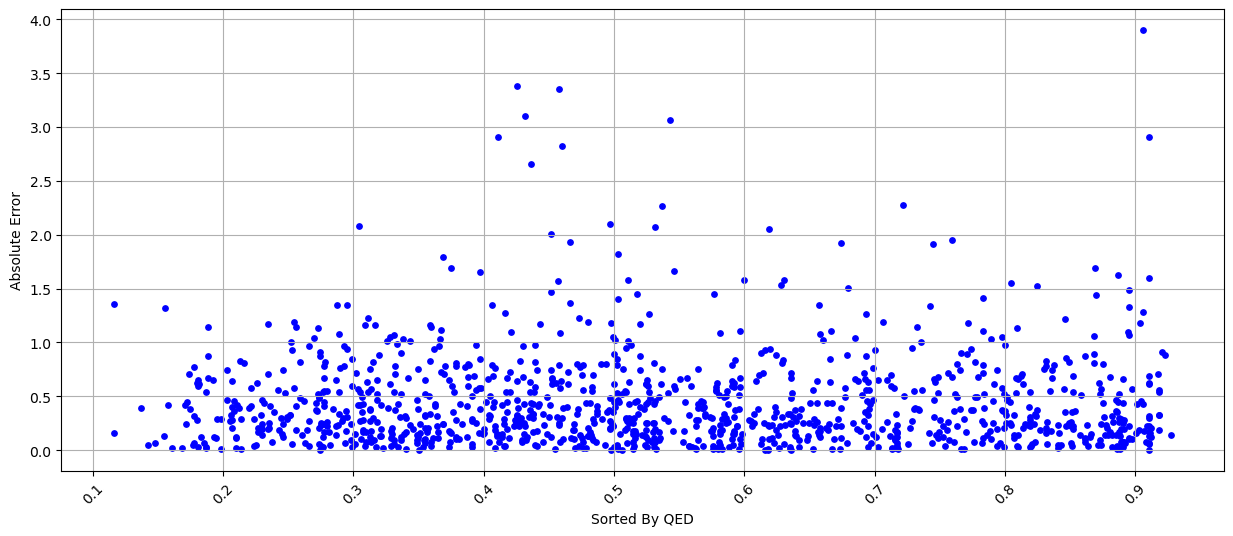

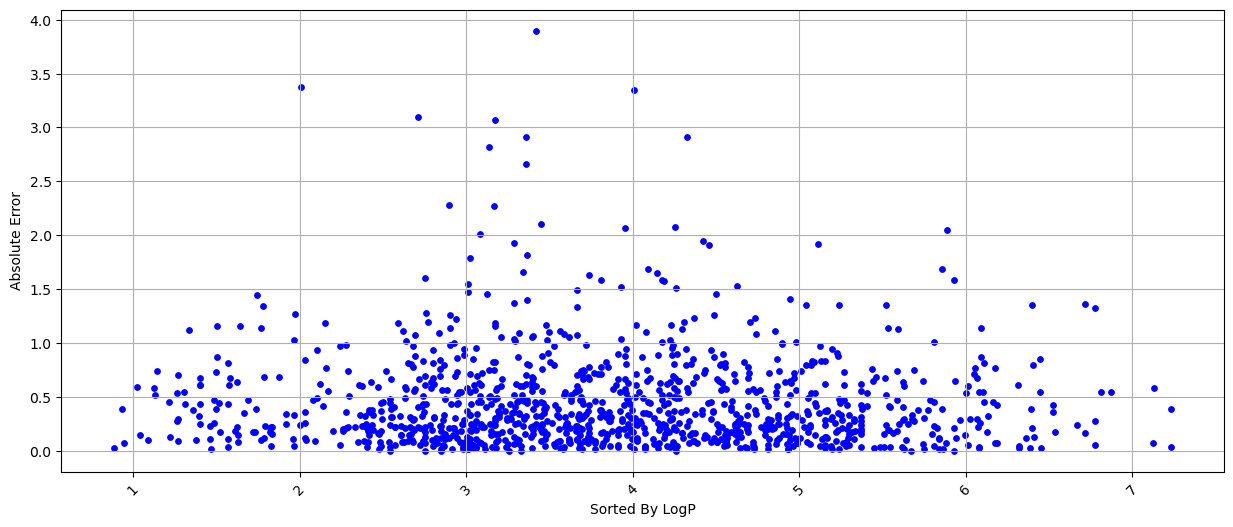

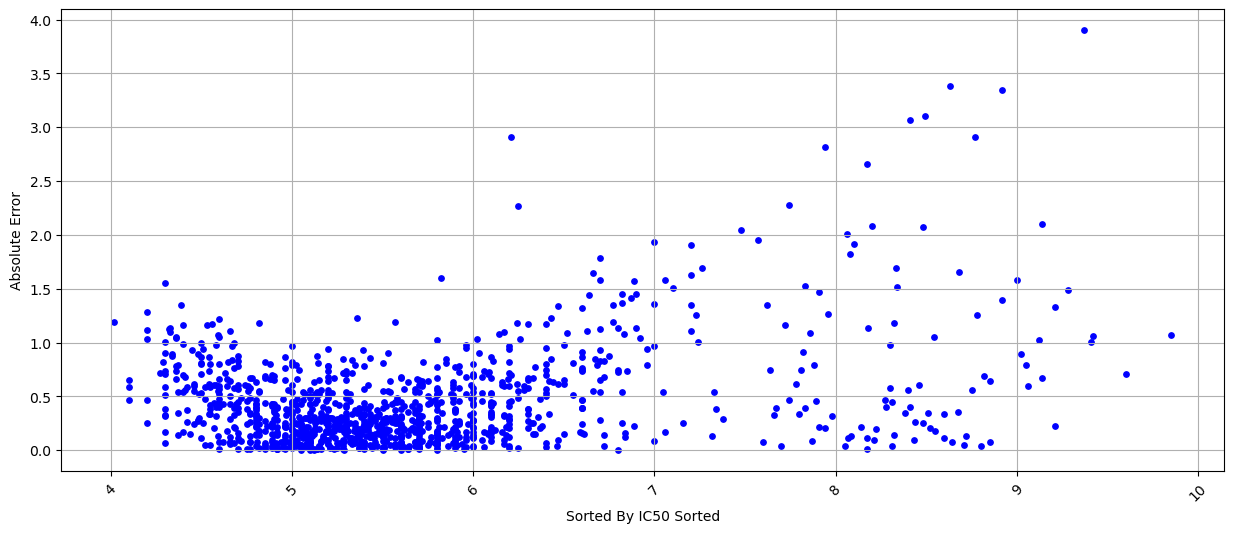

In [62]:
plot_graphs(df, results_df)

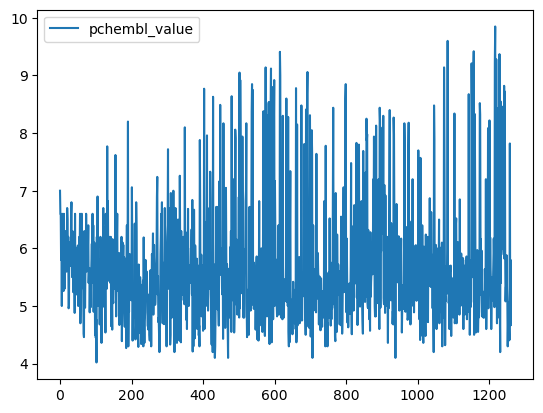

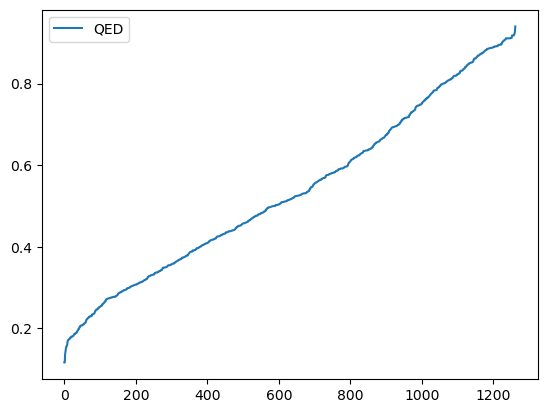

In [63]:
import random
df_copy=df.copy().sort_values(by="QED")#regular sort 
df_copy.plot(y="pchembl_value",use_index=False) #probabilities of each molecule being selected upon random selection without replacement
df_copy.plot(y="QED",use_index=False)

indices=df.nlargest(round(len(X)/10), ['QED']).index
X_test=X.copy()[indices]
y_test=y.copy()[indices]
smiles_test=smiles[indices]

X1=np.delete(X.copy(),indices,axis=0)
y1=np.delete(y.copy(),indices,axis=0)
smiles1=np.delete(smiles.copy(),indices,axis=0)


#X[df.nlargest(126, ['QED']).index].shape

In [64]:
#Calculating Discovery metrics on most drug-like candidates

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def perform_fcv_on_most_druglike(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    rmse=list()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]


    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        

        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]
        
        model = RandomForestRegressor(n_estimators=min(25,round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    # Optionally, save the results to a DataFrame
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
    })
    # Saving to CSV (optional)
    results_df.to_csv("unsorted_fcv_results_most_druglike.csv", index=False)

    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

PearsonRResult(statistic=-0.04560851679421039, pvalue=0.6120733548236827)
PearsonRResult(statistic=-0.24301623967775282, pvalue=0.006108606729828783)
PearsonRResult(statistic=-0.05973102911950737, pvalue=0.5064403633544821)
PearsonRResult(statistic=-0.053957727939277104, pvalue=0.5484561778632044)
PearsonRResult(statistic=0.3700897436725105, pvalue=1.996310701039665e-05)
PearsonRResult(statistic=0.44285028367153934, pvalue=2.0745735514841258e-07)
PearsonRResult(statistic=0.6560761247284281, pvalue=7.52650028308369e-17)
PearsonRResult(statistic=0.8550985530651842, pvalue=3.5183677394573113e-37)
PearsonRResult(statistic=0.809541081722861, pvalue=1.824926962061938e-30)


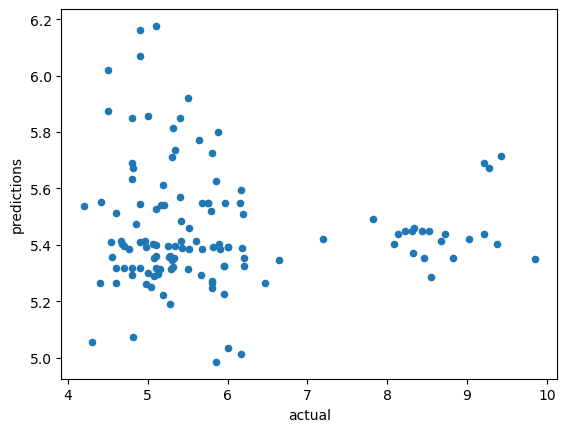

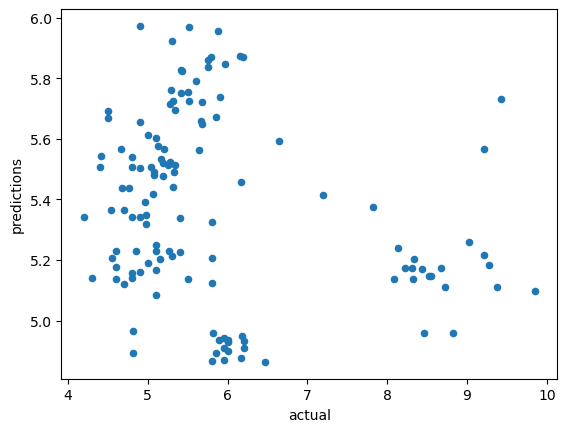

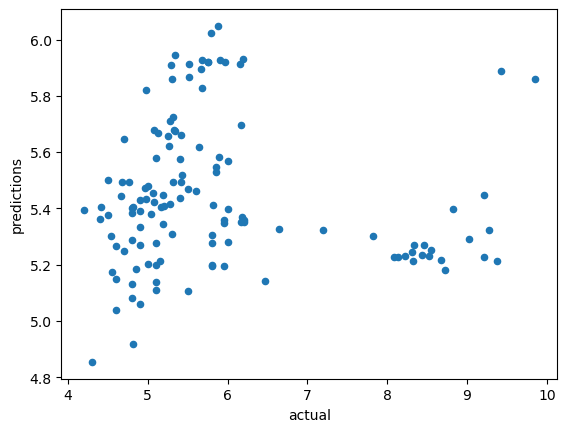

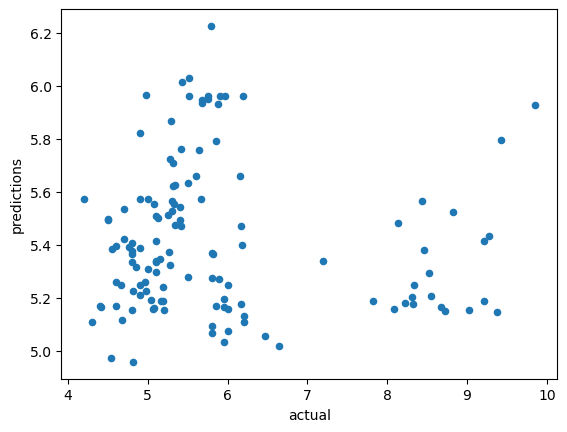

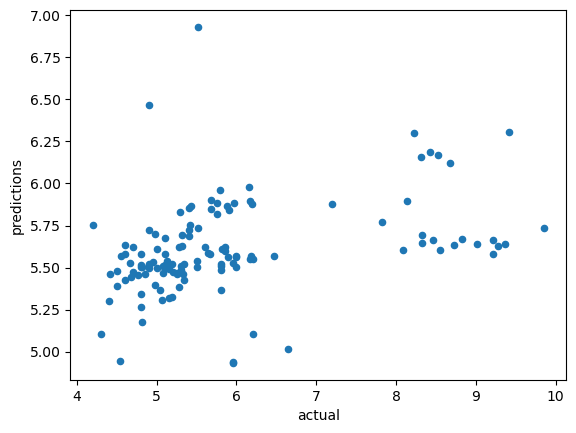

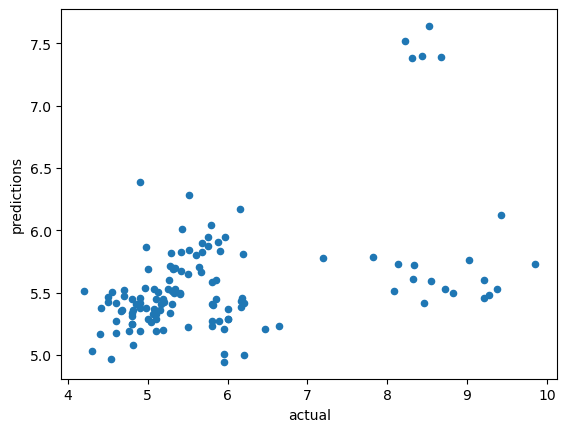

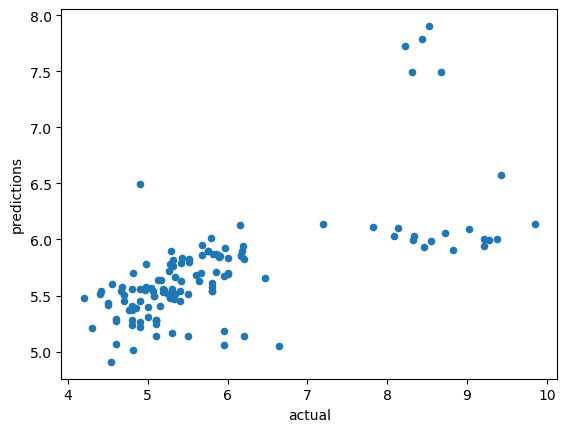

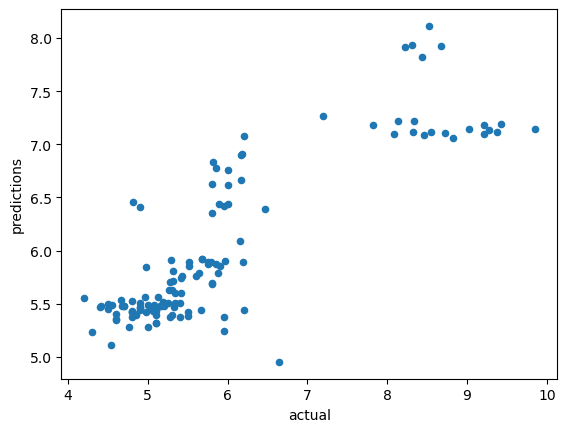

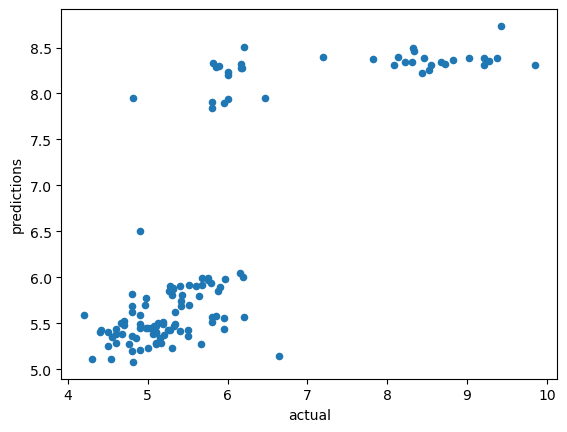

In [65]:


results_df2, false_disc2, true_disc2, true_ignore2, false_ignore2,rmse = perform_fcv_on_most_druglike(X1, y1, smiles1, sort_by=None, additional_info=df["QED"])

In [66]:
for i in np.arange(len(true_disc2)):
    print(true_disc2[i].shape)

(2, 3)
(12, 3)
(11, 3)
(13, 3)
(3, 3)
(8, 3)
(4, 3)
(1, 3)
(4, 3)


In [67]:
for i in np.arange(len(true_disc2)):
    print(false_disc2[i].shape)

(4, 3)
(31, 3)
(6, 3)
(22, 3)
(4, 3)
(3, 3)
(6, 3)
(1, 3)
(1, 3)


In [68]:
for i in np.arange(len(true_disc2)):
    print(true_ignore2[i].shape)

(73, 3)
(46, 3)
(71, 3)
(55, 3)
(73, 3)
(74, 3)
(71, 3)
(76, 3)
(76, 3)


In [69]:
for i in np.arange(len(true_disc2)):
    print(false_ignore2[i].shape)

(46, 3)
(36, 3)
(37, 3)
(35, 3)
(45, 3)
(40, 3)
(44, 3)
(47, 3)
(44, 3)


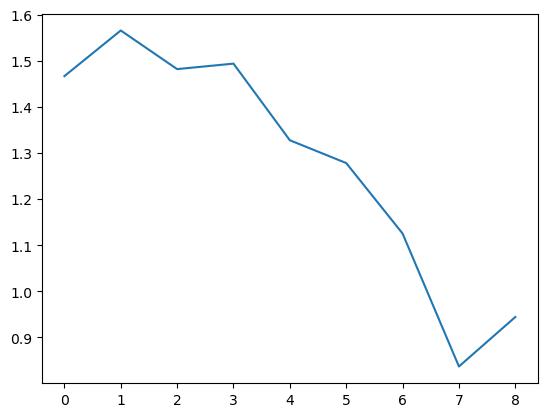

[1.4665322478294336, 1.5655343428553754, 1.4817907049557169, 1.4936379812622653, 1.327493641172282, 1.2780907536646897, 1.1253142390052375, 0.8369842129326053, 0.944226412349166]


In [70]:
plt.plot(rmse)
plt.show()
print(rmse)